In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import umap
import gc

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor

sns.set_style('white')

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224"
model = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/geneformer/geneformer-12L-30M/"
data_path = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_inputs/iHSC.dataset"
outpath = "/scratch/indikar_root/indikar1/cstansbu/geneformer"

In [3]:
def load_and_subset_data(data_path: str, num_cells: int = 100) -> pd.DataFrame:
    """Loads a dataset from disk, selects a subset of cells, and converts it to a Pandas DataFrame.

    Args:
        data_path (str): Path to the dataset file.
        num_cells (int, optional): Number of cells to include in the subset (default: 100).

    Returns:
        pd.DataFrame: The subset of data as a Pandas DataFrame.
    """

    data = load_from_disk(data_path)
    if num_cells > len(data):
        raise ValueError(f"Requested subset size ({num_cells}) exceeds dataset length ({len(data)})")

    data_subset = data.select([i for i in range(num_cells)])
    df = data_subset.to_pandas()

    return df

# Example usage:
df = load_and_subset_data(data_path, num_cells=100)

print(df['cell_type'].unique())

df.head()

['iHSC']


,input_ids,cell_id,cell_type,n_counts,dataset,length
0,"[12845, 8704, 947, 18004, 8351, 8431, 2896, 88...",AAACCCAAGGTTACCT_iHSC,iHSC,6558.0,iHSC,2048
1,"[12845, 8351, 1610, 24483, 3001, 2896, 8836, 9...",AAACCCAAGTTGAAGT_iHSC,iHSC,5488.0,iHSC,2048
2,"[8704, 8351, 18004, 8431, 947, 7632, 16181, 12...",AAACCCAAGTTGTCGT_iHSC,iHSC,4330.0,iHSC,1649
3,"[12845, 8351, 18004, 947, 3001, 8704, 8836, 28...",AAACCCACAGAAGCGT_iHSC,iHSC,3442.0,iHSC,1574
4,"[12845, 8351, 8431, 8704, 1912, 3011, 947, 198...",AAACCCACAGGAGGTT_iHSC,iHSC,14427.0,iHSC,2048


In [4]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
torch.cuda.empty_cache()

n_cells = 10000
# 0 for last layer, -1 for second to last
layer = -1 # 0 for last, -1 for second to last

# initiate EmbExtractor
embex = EmbExtractor(model_type="Pretrained",
                     num_classes=0,
                     max_ncells=n_cells,
                     emb_mode='cell',
                     emb_layer=layer,
                     emb_label=["cell_type", "dataset"],
                     forward_batch_size=20,
                     nproc=16,
                      )

# extracts embedding from input data
# input data is tokenized rank value encodings generated by Geneformer tokenizer (see tokenizing_scRNAseq_data.ipynb)
# example dataset: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
embs = embex.extract_embs(model,
                          data_path,
                          outpath,
                          "test")


  1%|          | 4/500 [00:03<06:45,  1.22it/s]

In [6]:
# break

In [7]:
def embedding_to_adata(df):
    """Converts a Pandas DataFrame with an embedding to an AnnData object.
    
    Args:
        df (pd.DataFrame): The input DataFrame, with numerical embedding columns and
            optional metadata columns.

    Returns:
        an.AnnData: The converted AnnData object.
    """
    
    cell_index = [f"C{x}" for x in range(df.shape[0])]
    
    metadata_cols = [col for col in df.columns if not str(col).isdigit()]
    obs = df[metadata_cols].copy()
    obs.index = cell_index
    
    df = df.drop(columns=metadata_cols)
    var_index = [f"D{x}" for x in range(df.shape[1])]
    
    adata = an.AnnData(df.to_numpy())
    adata.obs_names = cell_index
    adata.var_names = var_index
    adata.obs = obs

    return adata

    
adata = embedding_to_adata(embs)
adata

AnnData object with n_obs × n_vars = 5000 × 512
    obs: 'cell_type', 'dataset'

In [8]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(adata.X)

adata.obs['UMAP 1'] = embedding[:, 0]
adata.obs['UMAP 2'] = embedding[:, 1]

adata

AnnData object with n_obs × n_vars = 5000 × 512
    obs: 'cell_type', 'dataset', 'UMAP 1', 'UMAP 2'

In [9]:
adata.obs['dataset'].unique()

array(['tabula_sapiens', 'iHSC', 'old2_BMMC_HSPC', 'young2_HSC', 'pellin',
       'old1_BMMC_HSPC'], dtype=object)

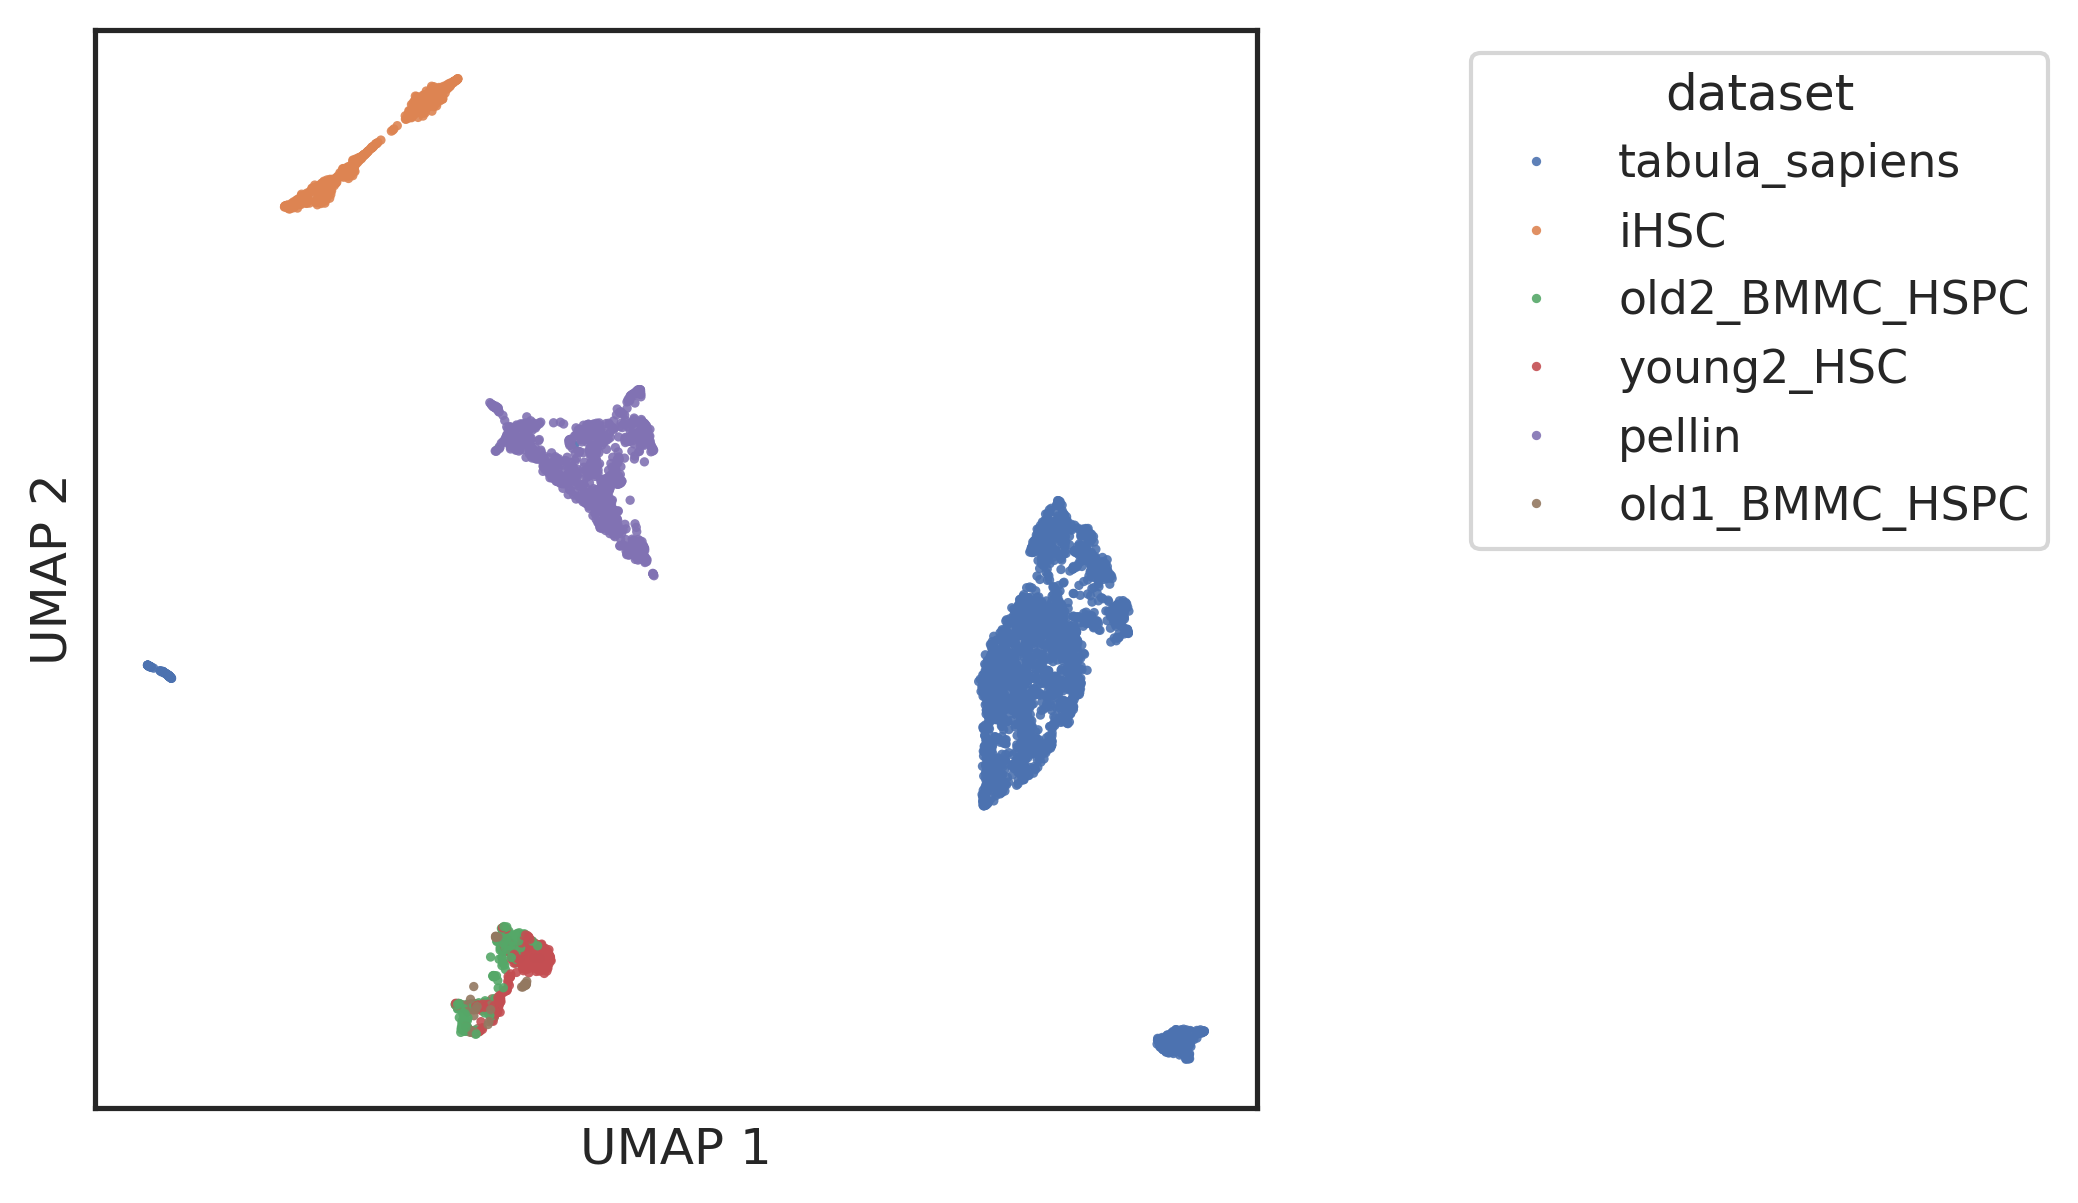

In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='none',
                lw=0.1,
                alpha=0.9,
                hue='dataset',
                s=5)


plt.xticks([])
plt.yticks([])


sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
comp_1 = 4
comp_2 = 5

sns.scatterplot(data=embs,
                x=comp_1,
                y=comp_2,
                ec='none',
                lw=0.1,
                alpha=0.9,
                hue='dataset',
                s=5)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
sc.tl.pca(adata, n_comps=5)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="cell_type",
    # Setting a smaller point size to get prevent overlap
    size=10,
)

In [ ]:
break

In [ ]:
sc.tl.leiden(adata, n_iterations=2)
sc.pl.umap(adata, color=["leiden"])

In [ ]:
break

In [ ]:
sns.scatterplot(data=embs,
                x=0,
                y=1,
                hue='dataset',
                s=10)

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.7, 1))

plt.gca().set_aspect('equal')

In [ ]:
break

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=21)
sc.tl.umap(adata, min_dist=0.2)

adata

In [ ]:
sc.pl.umap(adata, 
           color=['dataset'])

In [ ]:
break

In [ ]:
df = embs.copy()

sns.scatterplot(data=df,  
                x=0,
                y=2,
                alpha=0.6,
                s=10,
                palette="Set1",
                # legend=False,
                hue='dataset')

sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.4, 1))
